###  **This is a pretty long tutorial and I know how hard it is to go through, hopefully you may skip a few blocks of code if you need**

One of the oldest problem in Statistics is to deal with unbalanced data, for example, surviving data, credit risk, fraud. 

Basically in any data where either your success rate is too high or too low, models are almost irrelavant. This comes from the fact that we use a criteria around 1% to measure the accuracy of a model, ie, if my model predicts in the testing set 99% of the success (or failure depending on what you are trying to do), the model is a hero.

![title](images.png)

What happens with unbalanced data is that the success metric happening in around 1% (usually less than 10%), so if you have no model and predicts success at 1%, then the model passes the accuracy criteria.

In this post you will learn a 'trick' to deal with this type of data: *oversampling* and *undersampling*.
In this project I will skip the descriptive analysis hoping that we all want to focus on fraud analysis a bit more.


# Importing Libraries

In an early stage we will use a few of the most popular libraries such as pandas, numpy, matplotlib, sklearn, but also some for this particular type of problem such as imblearn, mlxtend and my favorite for logistic regression statsmodels.


In [32]:
#import libraries
#my functions
from homemade import new_stepwise
from homemade import confusion_matrix_lr
from homemade import save_confusionmatrix 
from homemade import order_correlation_matrix
from homemade import remove_features
from homemade import model_threshold_finder
from homemade import draw_precision_recall




#data manipulation
import pandas as pd
import numpy as np

#to plot stuff
import matplotlib.pyplot as plt
import seaborn as sns


#split training and testing
from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#machine learning 
import statsmodels.api as sm

#model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

I am also defining some of my output folder:

In [39]:
output_image = 'output/image/'
output_csv = 'output/csv/'

# Data Problem and Motivation

I have been working on a similar problem at work and I could not find a good source of information with I wanted. I knew I had to perform unbalanced data treatment and I wanted to use Logistic Regression and so I had to pick parts of code around and sew them together myself (thus this blog post).

The data used here was available in a kaggle competition 2 years ago in this link: https://www.kaggle.com/mlg-ulb/creditcardfraud. I have no extra knowledge of the data or data source whatsoever besides what is already in there. They do mention in the data description that a PCA analysis was performed and unfortunately, due to the nature of the business and privacy, they cannot release any additional information on the dataset.

This is what the data looks like:


In [3]:
#loads data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Factoring the X matrix for Regression
If we take a closer look at the amount of success and failure in the original data, we have:

In [4]:
#define our original variables
y = df['Class']
features =list(df.columns[0:len(df.columns)-1])
X = pd.get_dummies(df[features], drop_first=True)

p = sum(y)/len(y)
print("Percentage of Fraud: "+"{:.3%}".format(p));

Percentage of Fraud: 0.173%


In [5]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Now we know how low is the probability of a fradulent transactions to happen in our dataset (which here it will be treated as our success event). 

# Separating Test and Training
Let's separate the data in training and testing

In [6]:
#define training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


p_test = sum(y_test)/len(y_test)
p_train = sum(y_train)/len(y_train)

print("Percentage of Fraud in the test set: "+"{:.3%}".format(p_test))
print("Percentage of Fraud in the train set: "+"{:.3%}".format(p_train))


Percentage of Fraud in the test set: 0.172%
Percentage of Fraud in the train set: 0.173%


This way the percentage of success was kept within the split. 

Now because of our unbalanced data we need the dataset to have balanced success rate in order to validate the model. There are two ways of doing it: 
* Oversampling: which is basically floading the dataset with success events in a way that the percentage of success is closer to 50% (balanced) then the original set.
* Undersampling: which is reducing the unbalanced event, forcing the dataset to be balanced.

# Over and Under sampling

In [7]:
#generates both matrices for Over and Under sampling
#write  dataframe as a pandas dataframe and add the column names
#column names were removed from the dataframe when we performed the transformation
#column names will be useful down the road when we do a feature selection

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)

X = pd.DataFrame(X)
names = list(X.columns)
X_over = pd.DataFrame(X_over)
X_over.columns = names


#under
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

X_under = pd.DataFrame(X_under)
X_under.columns = names

p_over = sum(y_over)/len(y_over)
p_under = sum(y_under)/len(y_under)

print("Percentage of Fraud in the test set: "+"{:.3%}".format(p_over))
print("Percentage of Fraud in the train set: "+"{:.3%}".format(p_under))

Percentage of Fraud in the test set: 50.000%
Percentage of Fraud in the train set: 50.000%


Now the data has the same amount of success and failures.

# Modeling with Logistic Regression

Our recipe for modeling with Logistic Regression will be:

1. **Colinearity:** Check for colinearity in the X dataframe, this will impact what variables we need to remove versus not.


2. **Stepwise Logistic Regression:** Using the functions in the homemade.py file, perform backwards feature selection eliminating features in the models that contain p-value higher than a given alpha.


3. **Under versus Over sampling:** using precision-recall curve as well as model overall accuracy, we will choose one to proceed.


4. **Threshold:** given a specific threshold we will then identify the probability that maximixes the precision and recall function


Note: The IMO the threshold to call a fraud or success depends on how many false negative/positive you are willing to accept combined with any given financial value. In statistics, it's impossible to control both at the same time, so you need to pick and choose.

## Singularity and Colinearity

One of the things that the Logistic Regression does is invert the X matrix, if X has two columns with colinearity, in another words, a column is a linear combination of the other, we then have the issue of Singular Matrix, which is one of the worst problems a Statistician can face.

The functions below were created to solve this problem:

- function order_correlation_matrix: calculates correlation between all the variables of a given dataframe, removes the diagonal value, vectorized in var1, var 2 and their respective correlation and sort by the highest correlation.
- function remove_features: remove the feature until there is no correlation higher than a given corr_value, which is determined by the user.

## Feature selection 

We are also selecting only features that have p-values under alpha, so we have only features that impact the model [please see *homemade.py* to understand how I implemented].

In [8]:
#Define parameters 
#for the list of thresholds what is the minimum value and in how many bins we want to break it
start = 0 #starts in 0
interval = 0.05 #breaks 0.05 at a time
threshold_list = np.arange(start, 1.000001, interval) #creates the range

#defines value of correlation to be removed
correlation_max = 0.9
alpha = 0.05

modelname_under = 'Logistic Under'
modelname_over = 'Logistic Over'
modelname = 'Logistic No-sampling'

In [19]:
#no sampling
features = new_stepwise(X_train, y_train, alpha)
X_train_new = X_train[features]
lr=sm.Logit(y_train,X_train_new) #os stands for oversampling
lr = lr.fit()


V24
V12
Optimization terminated successfully.
         Current function value: 0.009452
         Iterations 12


In [9]:
#execute the functions over
over_features = new_stepwise(X_over, y_over, alpha)
X_over_new = X_over[over_features]

lr_os=sm.Logit(y_over,X_over_new) #os stands for oversampling
lr_os = lr_os.fit()

V20
Optimization terminated successfully.
         Current function value: 0.150160
         Iterations 14


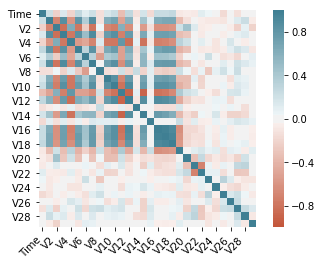

In [10]:
#correlation matrix 
corr = X_under.corr()

# plot the correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [11]:
#removes features with high collinearity
X_under = X_under[X_under.columns.difference(remove_features(X_under, correlation_max))] 
# stepwise backward selction 
under_features = new_stepwise(X_under, y_under, alpha)

lr_us=sm.Logit(y_under,X_under[under_features]) #os stands for undersampling
lr_us = lr_us.fit()


V22
V18
V13
V19
V24
V26
V15
V27
V11
Optimization terminated successfully.
         Current function value: 0.136531
         Iterations 13


# Choosing the variables 

There are many ways we can choose a model versus another:

1. we can choose based on the model that maximizes the precision versus recall curve.
2. we can choose a model that maximizes the financial impact combined with the classification
3. After choosing a model we can also define differently what is success versus failures.

Based on the Precision-Recall curve yesterday *Logistic Regression on top of Over Sampling method Performs* better.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


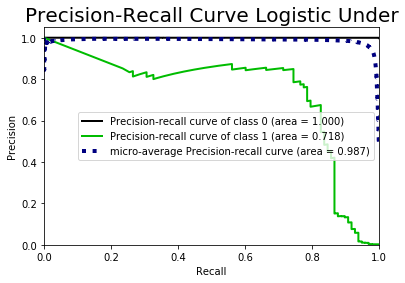

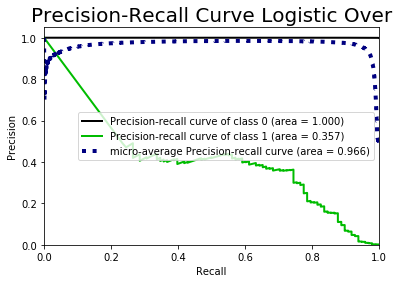

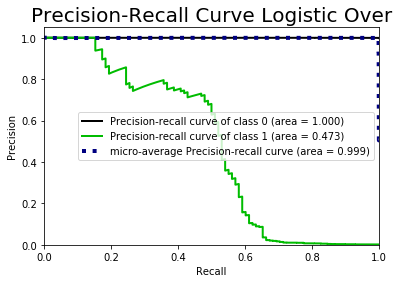

In [21]:
y_os_prob = lr_os.predict(X_test[over_features])
y_us_prob = lr_us.predict(X_test[under_features])
y_ns_prob = lr.predict(X_test[features])


classification_1 = model_threshold_finder(start, interval, y_test, y_os_prob, modelname_under)
classification_2 = model_threshold_finder(start, interval, y_test, y_us_prob, modelname_over)
classification_3 = model_threshold_finder(start, interval, y_test, y_ns_prob, modelname_over)

At this point we **discarted the under sampling method,** however we still need to define what is fraud versus not, in another words what is the probability threshold that will classify a transaction as fraud versus not. We will use the function below to do it so.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


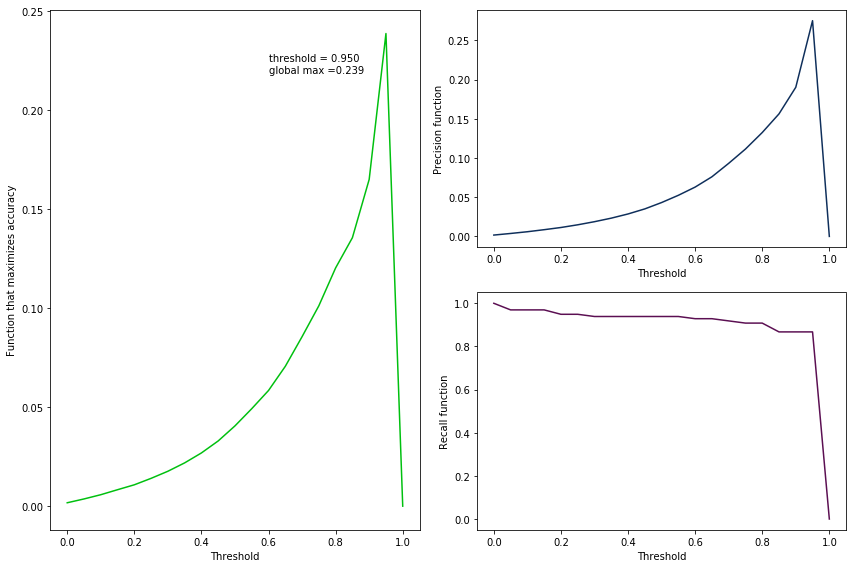

In [14]:
threshold = draw_precision_recall(threshold_list, classification_1)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


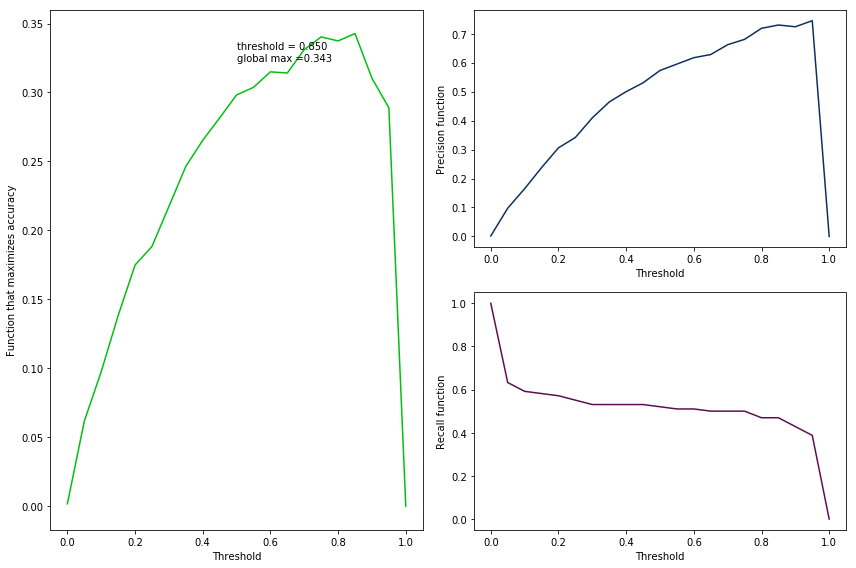

In [22]:
threshold = draw_precision_recall(threshold_list, classification_3)

## Scoring the model

To score the model we will use precision, recall, confusion matrix and potential financial risk:

Now the most expected part of this tutorial, which is basically checking how many "rights and wrongs" we are getting, considering the model was created based on a dataset with a 50% of fraud occurrences, and then tested in a set with 0.17% of fraud occurrences.<br>
**Voila:**

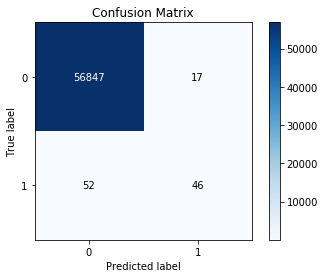

In [27]:
y_test_pred_ns = confusion_matrix_lr(output_image, 'lr', 0.85, lr, X_test[features], y_test, method = 'pred', )

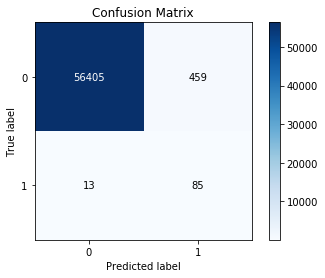

In [28]:
#generates pred and saves confusion matrix
y_test_pred_os = confusion_matrix_lr(output_image, 'lr_os', threshold, lr_os, X_test[over_features], y_test, method = 'pred', )

In [29]:
#from the number below you can see if the model is over or under predicting
print('Number of Frauds in real data %s' % sum(y_test))
print('Number of Frauds in prediction data %s' % sum(y_test_pred_os))

Number of Frauds in real data 98
Number of Frauds in prediction data 544


Now that we know the model is ok, let's see where we are getting it wrong. The plot below shows how many false negatives and false positives we have. We see a lot more false positives (we are saying a transaction was fradulent even though it was not). This come from the 0.95 threeshold above, if you increase that value to 0.99 for example, you will increase the amount of false negatives as well. The statistician need to decide what is the cut minimizes false negatives without affecting precision.


let's see what variables are more important to the model in asbolute value. In the chart below you can see the top 15 most relavant features:

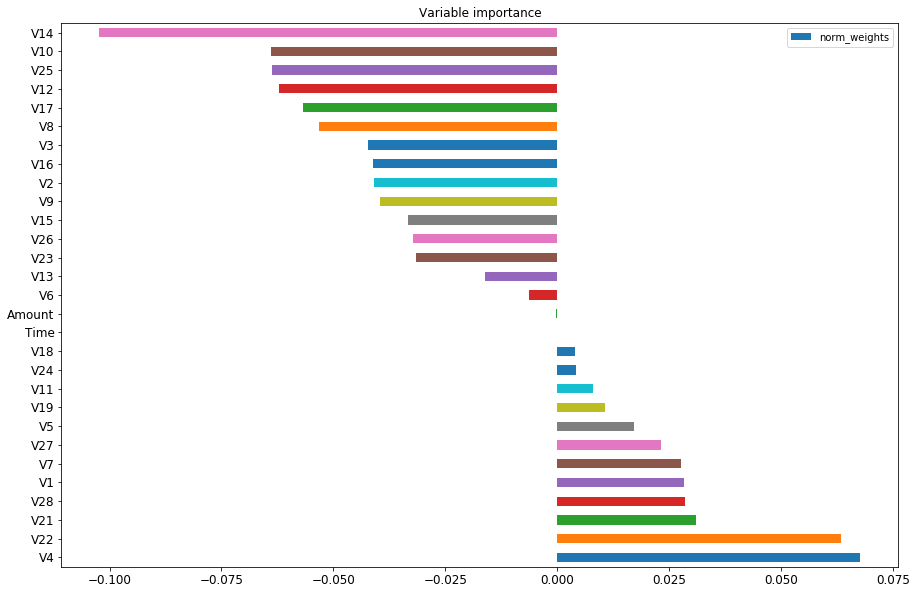

In [40]:
#calculate the weights
importance_list = lr_os.params
importance_list = importance_list.reset_index()
# #creates a dataframe for them and the coefficient names
importance_list.columns = ['names', 'weights']
# importance_list = importance_list[importance_list['names']!= 'const']
# #normalized absolute weights
importance_list['abs_weights'] = np.abs(importance_list['weights'])
total = sum(importance_list['abs_weights'])
importance_list['norm_weights'] = importance_list['weights']/total
importance_list['probabilities'] = np.exp(importance_list['weights'])
importance_list['probabilities_new'] = 1-importance_list['probabilities']

#select top 10 with higher importance
importance_list = importance_list.sort_values(by='norm_weights', ascending=False)
importance_list.to_csv(f'{output_csv}lr_importance_list_os.csv', index = False)

#plot them tcharam!
ax = importance_list['norm_weights'].plot(kind='barh', title ="Variable importance",figsize=(15,10),legend=True, fontsize=12);
ax.set_yticklabels(importance_list['names']);



ax.figure.savefig(f'{output_image}lr_importance_list_weights_os.PNG')
plt.show()

Now to visualize the weights we can see in the plot below which variables decrease x increase the likelihood of having a fradulent transaction. 

# Opportunities

In this file I focused a lot on evaluating models using precision, recall, accuracy, collinearity but ideally in a real business case, we would want to have the model that reduces the financial loses or at least includes financial analysis as a variable.  

I know this is a pretty long tutorial but hopefully you will not need to go through all the yak shaving I had to go through what I went through.

# Useful links and Aknowledgments

- *I want to thank Joana Diong for sharing how we can create good looking subplots https://scientificallysound.org/2016/06/09/matplotlib-how-to-plot-subplots-of-unequal-sizes/*